In [1]:
%load_ext autoreload

%autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train
from RNN2DFA.Training_Functions import make_test_set,make_train_set_for_target
from RNNexplainer import Explainer
import pandas as pd
import LTL2DFA as ltlf2dfa
from RNN2DFA.Extraction import extract
import pickle



In [2]:
# Reber grammar
from specific_examples import Reber_Grammar
rg=Reber_Grammar()
alphabet=rg.alphabet
generator_dfa=rg
sample_train_set=[]
for i in range(100):
    seq, _, _ = rg.get_one_example(maxLength=10)
    sample_train_set.append(seq)
    # print(rg.classify_word(rg.sequenceToWord(seq)))

In [3]:
import specific_examples
generator_dfa=specific_examples.Example4()
target_formula = generator_dfa.target_formula
alphabet = generator_dfa.alphabet
query_formulas = generator_dfa.query_formulas

print(target_formula)

F(a)


In [4]:
from sklearn.model_selection import train_test_split
def dict2lists(dictionary):
    X,y=[],[]
    for key in dictionary:
        X.append(key)
        y.append(dictionary[key])
    return X,y

def lists2dict(x,y):
    # both x and y should have same length
    assert len(x)==len(y), "Error dimension"
    d={}
    n=len(x)
    for idx in range(n):
        d[x[idx]]=y[idx]
    return d

# for each example, specify a different generating function
file_name = "benchmarks/" + target_formula.replace(" ", "_")+".pkl"

if not os.path.isfile(file_name):

    if(target_formula == "balanced parentheses"):

        train_set = generator_dfa.get_balanced_parantheses_train_set(8000, 2, 50, max_train_samples_per_length=3000,
                                                                     search_size_per_length=2000, lengths=[i for i in range(maximum_sequence_length+1)])

    elif(target_formula == "email match"):

        train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet, lengths=[i for i in range(maximum_sequence_length+1)],
                                              max_train_samples_per_length=1000,
                                              search_size_per_length=3000, deviation=200)

        # generate more examples that match the regular expression
        matching_strings = generator_dfa.generate_matching_strings(
            n=10800, max_length=50)
        for string in matching_strings:
            train_set[string] = True

    elif(target_formula == "alternating bit protocol"):

        train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet, lengths=[i for i in range(maximum_sequence_length+1)],
                                              max_train_samples_per_length=1000,
                                              search_size_per_length=3000, deviation=250)

        # generate more examples that match the regular expression
        matching_strings = generator_dfa.generate_matching_strings(
            n=105000, max_sequence_length=50)
        for string in matching_strings:
            train_set[string] = True
    elif(target_formula == 'G(a->X(b))'):
        train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet, lengths=[i for i in range(maximum_sequence_length+1)],
                                              max_train_samples_per_length=1000,
                                              search_size_per_length=3000, deviation=20)

    else:
        train_set = make_train_set_for_target(generator_dfa.classify_word, alphabet, lengths=[i for i in range(maximum_sequence_length+1)],
                                              max_train_samples_per_length=10000,
                                              search_size_per_length=30000, deviation=20)

    # now save the dataset to file
    with open(file_name, "wb") as f:
        pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

else:
    # load the dataset
    print("loading from previously stored benchmarks")

    def load_obj(name):
        with open(name, "rb") as f:
            return pickle.load(f)
    train_set = load_obj(file_name)



loading from previously stored benchmarks


In [5]:
print(target_formula)

num_layers = 2
num_hidden_dim = 10
input_dim = 3
iterations = 1
stop_threshold = 0.0005
RNNClass = LSTMNetwork


# print ratio
cnt = 0
examples_per_length = [0 for i in range(51)]
for key in train_set:
    if(train_set[key]):
        cnt += 1

    examples_per_length[len(key)] += 1

total_samples = len(train_set)
print("out of ", total_samples, " sequences", cnt,
      " are positive. (percent: ", float(cnt/total_samples), ")")
print("examples per length:", examples_per_length)

# split train:test
X, y = dict2lists(train_set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_set = lists2dict(X_train, y_train)
test_set = lists2dict(X_test, y_test)
train_set_size = len(train_set)
test_set_size = len(test_set)

# intentionally pushing "" (empty string) in train_set
if('' not in train_set):
    train_set[''] = test_set['']
    print("Empty string status:", train_set[''])
else:
    print("Empty string was already included in train set")
    print("Empty string status:", train_set[''])

print("size of train set:", train_set_size)
print("size of test set:", test_set_size)

print("configurations: layers: ", num_layers,
          "hidden dimension: ", num_hidden_dim,
          "input dim: ", input_dim,
          "network: ", RNNClass,
          "stop threshold: ", stop_threshold)


# define rnn
rnn = RNNClassifier(alphabet, num_layers=num_layers,
                    hidden_dim=num_hidden_dim, RNNClass=RNNClass, input_dim=input_dim, target=target_formula)

try:
    # train the model
    if not os.path.isfile("model/"+target_formula+".model"):
        mixed_curriculum_train(rnn, train_set, stop_threshold=stop_threshold)
        rnn.save_model()
    else:
        print("loading already saved model")
        rnn.load_model()
except:
    print("Training error: however moving on as life also goes on" )
    
rnn.renew()
dfa_from_rnn = rnn
# statistics

def percent(num, digits=2):
    tens = pow(10, digits)
    return int(100*num*tens)/tens

print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

pos = 0
rnn_target = 0
for w in test_set:
    if generator_dfa.classify_word(w):
        pos += 1

    if dfa_from_rnn.classify_word(w) == generator_dfa.classify_word(w):
        rnn_target += 1
test_acc = percent(rnn_target/test_set_size)
print("rnn score against target on test set:                             ",
        rnn_target, "("+str(test_acc)+")")



F(a)
out of  6088  sequences 3519  are positive. (percent:  0.5780223390275953 )
examples per length: [1, 3, 9, 27, 52, 84, 148, 276, 532, 1044, 1068, 710, 502, 316, 234, 150, 92, 78, 58, 42, 30, 30, 26, 24, 24, 22, 24, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Empty string was already included in train set
Empty string status: False
size of train set: 4870
size of test set: 1218
configurations: layers:  2 hidden dimension:  10 input dim:  3 network:  <class 'RNN2DFA.LSTM.LSTMNetwork'> stop threshold:  0.0005
The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
loading already saved model
testing on train set, i.e. test set is train set
rnn score against target on test set:                              1218 (100.0)


F(b)


positive traces---> 
[]


negative traces---> 
[]



Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: false
Learning took:  0.06158089637756348  s
EQ test took  0.03981828689575195  s
new counterexample: ab  should be accepted by implementation


positive traces---> 
['ab']


negative traces---> 
[]



0  iteration complete



Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: true
Learning took:  0.055703163146972656  s
EQ test took  0.0009870529174804688  s
new counterexample:   should be rejected by implementation


positive traces---> 
['ab']


negative traces---> 
['']



1  iteration complete



start formula depth: 1
Before normalization: x0
Learning formula with depth 0
Number of subformulas: 1
learned LTL formula: a
Learning took:  0.08935403823852539  s
EQ test took  0.02228093147277832  s
new counterexample: a  should be rejected by implementation


positive traces---> 
['ab']


negative traces---> 
['', 'a']



2  i

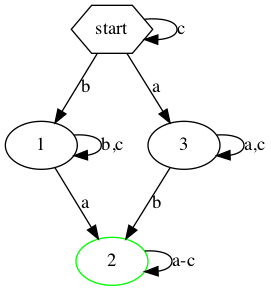

doing minimization from  4  states to  4  states


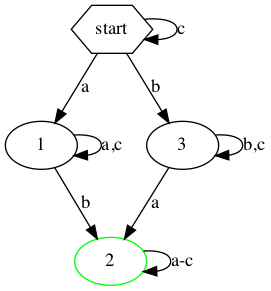


Time taken to extract lstar-dfa: 0.12879419326782227
returned flag: True
transitions:->
number of states of the dfa: 4
Explanation matches RNN: 100.0
RNN matches ground truth: 100.0
Explanation matches ground truth: 100.0
Lstar matches RNN: 100.0
Lstar matches ground truth: 100.0


In [18]:
timeout = 10
maximum_sequence_length = 50
maximum_formula_depth = 50
epsilon = 0.05
delta = 0.05


# use a query LTL formula
query_formula="F(b)"
print(query_formula)
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula, token="bal")
# print(query_dfa)
"""  
Create initial samples
"""


from RNNexplainer import Traces
traces=Traces(rnn, alphabet, token="bal")
traces.label_from_network([])
traces.write_in_file()




from PACTeacher.pac_teacher import PACTeacher as Teacher 
explainer=Explainer(alphabet=[character for character in alphabet], token="bal")
teacher = Teacher(dfa_from_rnn,epsilon=.03, delta=.03, max_trace_length=20, max_formula_depth=10, query_dfa=query_dfa)



import time
start_time=time.time()
from multiprocessing import Process, Queue
explainer, flag, learner_time, verification_time = teacher.teach(explainer, traces, timeout = timeout)
end_time=time.time()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)




new_delta = None
new_epsilon = None
if(not flag):
    print("incomplete formula")
    new_delta, new_epsilon = teacher.calculate_revised_delta_and_epsilon()
    print(new_delta, new_epsilon)


print("returned counterexamples:", teacher.returned_counterexamples)

print("time learner:", learner_time)
print('time verifier:', verification_time)
print("Random words:", teacher.number_of_words_checked)
print("\nTime taken:", end_time-start_time)



run_lstar = True
if(run_lstar):
        print("\n\n\n\n")
        # compare with dfa from lstar_algorithm
        dfa_from_rnn.renew()
        start_time_lstar = time.time()
        dfa_lstar, lstar_flag = extract(rnn, query=query_dfa, max_trace_length=maximum_sequence_length, epsilon=delta,
                                        delta=delta, time_limit=timeout, initial_split_depth=10, starting_examples=[])
        end_time_lstar = time.time()

        dfa_lstar.draw_nicely(
            filename=target_formula+":"+query_formula+"_"+str(epsilon)+"_"+str(delta))
        dfa_lstar = dfa_lstar.minimize_()
        dfa_lstar.draw_nicely(
            filename=target_formula+":"+query_formula+"_"+str(epsilon)+"_"+str(delta))

        
        print("\nTime taken to extract lstar-dfa:",
                end_time_lstar-start_time_lstar)
        print("returned flag:", lstar_flag)
        print("transitions:->")
        # print(dfa_lstar.delta)
        num_lstar_states = len(dfa_lstar.Q)
        print("number of states of the dfa:", num_lstar_states)


performance_explanation_with_rnn = performance_rnn_with_groundtruth = performance_explanation_with_groundtruth = 0
lstar_performance_explanation_with_rnn = lstar_performance_explanation_with_groundtruth = 0

test_set_size = 0
for w in train_set:

    

    dfa_from_rnn.renew()

    test_set_size += 1
    verdict_rnn = dfa_from_rnn.classify_word(w)
    verdict_target = generator_dfa.classify_word(w)
    verdict_ltl = explainer.dfa.classify_word(w)
    verdict_query = query_dfa.classify_word(w)

    if(run_lstar):
        verdict_lstar = dfa_lstar.classify_word(w)

    if (verdict_rnn and verdict_query) == verdict_ltl:
        performance_explanation_with_rnn += 1
    if verdict_rnn == verdict_target:
        performance_rnn_with_groundtruth += 1
    if verdict_ltl == (verdict_target and verdict_query):
        performance_explanation_with_groundtruth += 1
    if(run_lstar):
        if (verdict_rnn and verdict_query) == verdict_lstar:
            lstar_performance_explanation_with_rnn += 1
        if verdict_lstar == (verdict_target and verdict_query):
            lstar_performance_explanation_with_groundtruth += 1

if(test_set_size != 0):
    print("Explanation matches RNN:", str(
        percent(performance_explanation_with_rnn/test_set_size)))

    print("RNN matches ground truth:", str(
        percent(performance_rnn_with_groundtruth/test_set_size)))

    print("Explanation matches ground truth:", str(
        percent(performance_explanation_with_groundtruth/test_set_size)))

    if(run_lstar):
        print("Lstar matches RNN:", str(
            percent(lstar_performance_explanation_with_rnn/test_set_size)))

        print("Lstar matches ground truth:", str(
            percent(lstar_performance_explanation_with_groundtruth/test_set_size)))



if(not run_lstar):
    num_lstar_states = None
    start_time_lstar = 0
    end_time_lstar = 0
    lstar_performance_explanation_with_rnn = 0
    lstar_performance_explanation_with_groundtruth = 0
    lstar_flag = False


